### ALL SIMULATION USING DEVITO CODE

In [1]:
import numpy as np
%matplotlib inline

from examples.seismic import demo_model, plot_velocity, plot_perturbation

from devito import configuration
configuration['log-level'] = 'WARNING' # This added simply to reduce clutter in the output

# This cell consists a set of useful imports. Feel free to modify if you need anything else or would like
# remove a redundant import.

import time
import numpy as np
from scipy.ndimage import gaussian_filter # This filter will be used to generate the smoothed model
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver, TimeAxis
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord
from examples.seismic import RickerSource
from examples.seismic import TimeAxis

# Reduce the level of output printed by Devito
from devito import configuration
configuration['log-level'] = 'WARNING'


In [2]:
import pickle
import numpy as np

def load_shots(file_name=None):
    """Load a `pickle` to a `numpy.ndarray`.

    Parameters
    ----------
    filename: str, optional by default shot_number_#.dat
        The filename to save the data as a `pickle`

    Returns
    -------
    array: `numpy.ndarray`
        The data

    """

    with open(file_name, "rb") as f:
        array = np.asarray(pickle.load(f), dtype=float)
    return array

# circle - devito - forward
There is difference between nbl=10 and nbl=40, which the later one gives better result.

## the set dt = 0.5 output the same size of true_d comparing the set of dt = 0.0005 in Spyro

1 sources

101 receivers

mesh $1.0km \times 1.0km$

pml = 0.4 km = $ 40 \times 10m $ = 400m || nbl = 40

Ricker : feq = 10 HZ ||  f0 = 0.01kHz

tf = 1s, dt=0.0005s || tn = 1000ms , dt = 0.5 ms


# This is the old method

Running Time - devito: 0.91 seconds


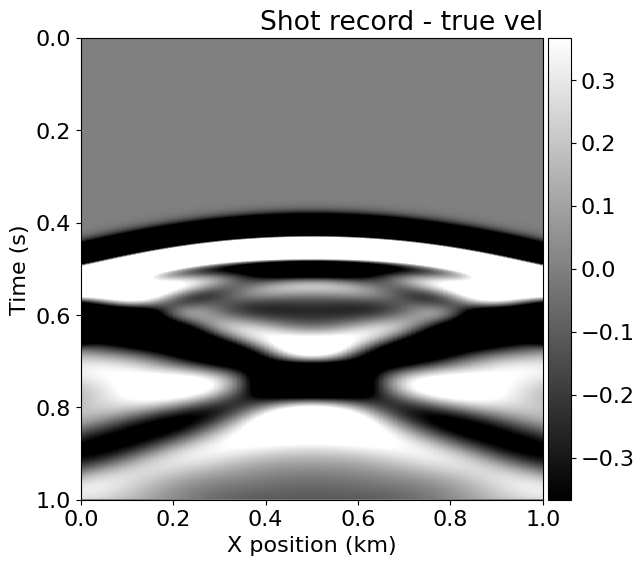

In [21]:
import time
from examples.seismic import demo_model, plot_velocity, plot_image, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

#Set the number of boundary layers
nbl = 40

v = np.full(shape, 2.5, dtype=np.float32)  # 全部初始化为2.5 km/s

# 定义圆的中心和半径
center_x, center_y = shape[0] // 2, shape[1] // 2  # 圆心位置
radius = 30  # 半径为50格

# 遍历每个点，如果点在圆内，则设置速度为3 km/s
for x in range(shape[0]):
    for y in range(shape[1]):
        if (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2:
            v[x, y] = 3.0

#True Vp model
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, space_order=4, nbl=nbl, bcs="damp")

# #Smooth/Initial Vp model
# model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,  
#                      origin=origin, shape=shape, spacing=spacing, nbl=nbl,
#                     grid = model.grid, dt=0.5, dtype=np.float64)

v1 = np.full(shape, 2.5, dtype=np.float32)  # 全部初始化为2.5 km/s
#True Vp model
model0 = Model(vp=v1, origin=origin, shape=shape, spacing=spacing, space_order=4, nbl=nbl, bcs="damp")

# Define acquisition geometry: 
# nshots = 9  # Number of shots to used to generate the gradient
nreceivers = 101  # Number of receiver locations per shot 
# fwi_iterations = 5  # Number of outer FWI iterations

# Note, distances below correspond to meters.
# Position the source:
src_coordinates = np.empty((1, 2))
src_coordinates[0, 1] = np.array(model.domain_size[1]) * .5
src_coordinates[0, 0] = 20.

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Create the Geometry
# Along with storing the source and receiver locations defined above this will work out the points in time at
# at which we'll need the source signal and compute them according to the definiction of the Ricker-wavelet
t0 = 0.
tn = 1000. # 1000ms
f0 = 0.010 # 10Hz (=0.01 kHz)
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

solver = AcousticWaveSolver(model, geometry, space_order=4)

# Compute synthetic data with forward operator and calculate the total running time
t1=time.time()
true_d,a, b = solver.forward(vp=model.vp)
end_time = time.time()
running_time = end_time - t1
# Print the running time
print("Running Time - devito: {:.2f} seconds".format(running_time))

# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

# plot the shotrecord
# Plot shot record for true and smooth velocity model and the difference
plt.title('Shot record - true vel', loc='right')
plot_shotrecord(true_d.data, model, t0, tn) # In reality, this would be our data from the experiment
# plt.title('Shot record - smoothed vel', loc='right')
# plot_shotrecord(smooth_d.data, model, t0, tn) # This is our model data
# plt.title('Shot record - difference vel', loc='right')
# plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn) # This is the data residual
# # # plot_image(u.data[80, 40:-40,40:-40], cmap="seismic")
# plot_image( u.data[80, 40:-40,40:-40], vmin=-1e-1, vmax=1e-1, colorbar=True, cmap="gray")

In [ ]:
true_d

### Some visualizations

In [22]:
# # We can plot the time signature to see the wavelet
# geometry.src.show()

# # Plot acquisition geometry
# plot_velocity(model, source=geometry.src_positions,
#               receiver=geometry.rec_positions[::4, :])


# plot the shotrecord
# Plot shot record for true and smooth velocity model and the difference
# plt.title('Shot record - true vel', loc='right')
# plot_shotrecord(true_d.data, model, t0, tn) # In reality, this would be our data from the experiment
# plt.title('Shot record - smoothed vel', loc='right')
# plot_shotrecord(smooth_d.data, model, t0, tn) # This is our model data
# plt.title('Shot record - difference vel', loc='right')
# plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn) # This is the data residual
# # # plot_image(u.data[80, 40:-40,40:-40], cmap="seismic")
# plot_image( u.data[80, 40:-40,40:-40], vmin=-1e-1, vmax=1e-1, colorbar=True, cmap="gray")

### Other way to set dt manually althought there is no difference between dt=5e-4 and dt=1

In [23]:
# new_dt = 5e-4
# true_d.resample(dt=new_dt)
# true_d.data

# This is the new method
In case to comparable with Spyro. The acoustic wave equation with this damping mask can be rewritten as:
From 
\begin{equation} 
  m \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \nabla^2 u(\mathbf{x},t) + \eta \frac{\partial u(\mathbf{x},t)}{\partial t}=q  
\end{equation}

To
\begin{equation} 
  \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \frac{1}{m}\nabla^2 u(\mathbf{x},t) +  \frac{1}{m} \eta \frac{\partial u(\mathbf{x},t)}{\partial t}=\frac{q}{m}
\end{equation}

Where the PDE becomes:
\begin{equation} 
  pde = \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \frac{1}{m}\nabla^2 u(\mathbf{x},t) +  \frac{1}{m} \eta \frac{\partial u(\mathbf{x},t)}{\partial t}
\end{equation}

where $\eta$ is the damping mask which is equal to $0$ inside the physical domain and increasing inside the sponge layer. Multiple choice of profile can be chosen for $\eta$ from, e.g., linear to exponential.

In [13]:

# # Model with fixed time step value
# class ModelBench(Model):
#     """
#     Physical model used for accuracy benchmarking.
#     The critical dt is made small enough to ignore
#     time discretization errors
#     """

#     @property
#     def critical_dt(self):
#         """Critical computational time step value."""
#         return .1
    
# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (20., 20.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

#Set the number of boundary layers
nbl = 40

v = np.full(shape, 2.5, dtype=np.float32)  # 全部初始化为2.5 km/s

# 定义圆的中心和半径
center_x, center_y = shape[0] // 2, shape[1] // 2  # 圆心位置
radius = 30  # 半径为50格

# 遍历每个点，如果点在圆内，则设置速度为3 km/s
for x in range(shape[0]):
    for y in range(shape[1]):
        if (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2:
            v[x, y] = 3.0

#True Vp model
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, space_order=8, nbl=nbl, bcs="damp")

vp = model.vp.data

t0 = 0
tn=1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
# dt = 2  # Time step from model grid spacing in ms

time = TimeAxis(start=t0, stop=tn, step=dt)

u = TimeFunction(name="u", grid=model.grid, 
                 time_order=2, space_order=2,
                 save=time.num)

# pde = (model.m )* u.dt2 - u.laplace + model.damp * u.dt
pde =  u.dt2 - (1/model.m )*u.laplace + (1/model.m )*model.damp * u.dt

stencil = Eq(u.forward, solve(pde, u.forward))

# Src is halfway across model, at depth of 20 m.
x_extent, _ = model.domain_size
src_coords = [20, x_extent/2]

f0 = 0.01  # kHz, peak frequency.
src = RickerSource(name='src', grid=model.grid, f0=f0, coordinates=src_coords, time_range=time)
src_term = src.inject(field=u.forward, expr=src * dt**2 * model.m)

# Recs are distributed across model, at depth of 20 m.
x_locs = np.linspace(0, x_extent, 101)
rec_coords = [(980, x) for x in x_locs]

rec = Receiver(name='rec', npoint=101, grid=model.grid, coordinates=rec_coords, time_range=time)

rec_term = rec.interpolate(u.forward)

op_fwd = Operator([stencil] + src_term + rec_term)

op_fwd(dt=model.critical_dt)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.02483599999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=1.6000000000000003e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.00020599999999999964, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

## $ dt \leq \frac{dx}{c \sqrt{d}} $

size of grid : dx = 10 m

c = 3km /s

spacing order = 2

which is $ dt \leq \frac{10}{3000 \sqrt{2}}  = 0.00236 s = 2.36ms $


In [14]:
rec.data

Data([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      ...,
      [0.00575349, 0.00532689, 0.0043328 , ..., 0.0043328 , 0.00532689,
       0.00575349],
      [0.00573995, 0.00500054, 0.00399449, ..., 0.00399449, 0.00500054,
       0.00573995],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]], dtype=float32)

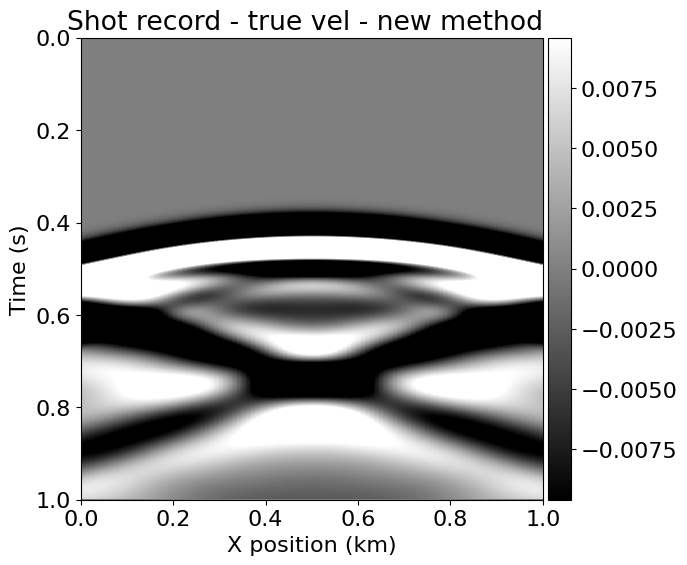

In [8]:
plt.title('Shot record - true vel - new method', loc='right')
plot_shotrecord(rec.data, model, t0, tn)

# Scaling Devito by 1/dx^2
This is because in the finite difference method, the space is already divided by dx^2 during discretization. See the reference denoted in the Devito tutorial https://slimgroup.github.io/Devito-Examples/tutorials/accuracy/ 

The spatial discretiation for Devito:
\begin{equation}
\begin{aligned}
\Delta \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t})= \sum_{j=1}^{j=\frac{k}{2}} \Bigg[\alpha_j \Bigg(&
\mathbf{u}(\mathbf{x+jdx},\mathbf{y},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x-jdx},\mathbf{y},\mathbf{z},\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y+jdy},\mathbf{z},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y-jdy},\mathbf{z}\mathbf{t}) + \\
&\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z+jdz},\mathbf{t})+\mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z-jdz},\mathbf{t})\Bigg) \Bigg] + \\
&3\alpha_0 \mathbf{u}(\mathbf{x},\mathbf{y},\mathbf{z},\mathbf{t}).
\end{aligned}
\end{equation}


In [70]:
grid = model.grid
spacing = grid.spacing
dx2 = spacing[0]**2
dy2 = spacing[1]**2

print(f"Grid spacing: {spacing}") # in meters
print(f"dx^2: {dx2}, dy^2: {dy2}") # in meters

Grid spacing: (10.0, 10.0)
dx^2: 100.0, dy^2: 100.0


In [71]:
1/(model.spacing [0]**2)

0.01

In [73]:
rec.data

Data([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      ...,
      [-4.5192388e-11,  6.1713530e-11, -6.3868841e-11, ...,
       -6.8445943e-11,  6.5197424e-11, -4.6242201e-11],
      [ 1.4668738e-11, -7.5687781e-12,  3.0861456e-11, ...,
        3.9845228e-11, -1.8013544e-11,  2.5893189e-11],
      [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [72]:
rec.data * 1/(model.spacing [0]**2)

Data([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      ...,
      [-4.5192387e-13,  6.1713530e-13, -6.3868843e-13, ...,
       -6.8445943e-13,  6.5197424e-13, -4.6242198e-13],
      [ 1.4668739e-13, -7.5687781e-14,  3.0861457e-13, ...,
        3.9845227e-13, -1.8013543e-13,  2.5893187e-13],
      [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

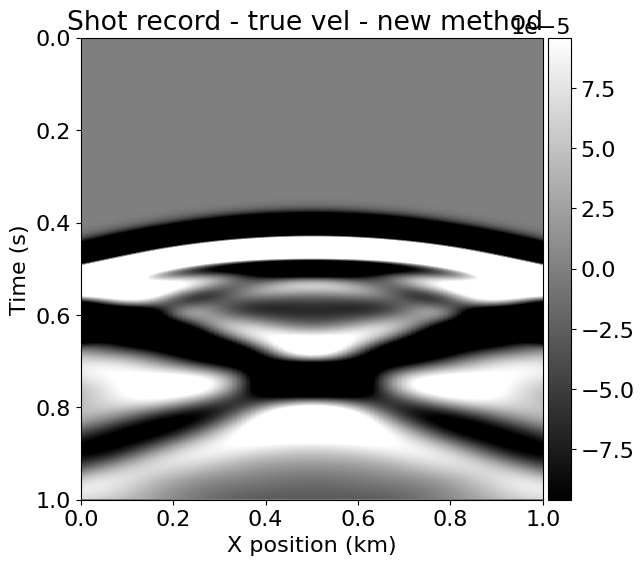

In [64]:
rec_data = rec.data * (1/(model.spacing [0]**2))

plt.title('Shot record - true vel - new method', loc='right')
plot_shotrecord(rec_data, model, t0, tn)

In [68]:
from scipy.special import hankel2
import numpy as np
from scipy.special import hankel2
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, RickerSource, Receiver, TimeAxis, AcquisitionGeometry
from devito import set_log_level

# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1

# Source and receiver coordinates
sx, sz = src_coordinates[0, :]
rx, rz = rec_coordinates[0, :]

# Fine grid model
c0 = 1.5
model = ModelBench(vp=c0, origin=(0., 0.), spacing=(.5, .5), bcs="damp",
                   shape=(801, 801), space_order=20, nbl=40, dtype=np.float32)

# Number of time steps
nt = 1501
# Time axis
dt = 0.1
t0 = 0.
tn = dt * (nt-1)
time = np.linspace(t0, tn, nt)

# Define a Ricker wavelet shifted to zero lag for the Fourier transform
def ricker(f, T, dt, t0):
    t = np.linspace(-t0, T-t0, int(T/dt))
    tt = (np.pi**2) * (f**2) * (t**2)
    y = (1.0 - 2.0 * tt) * np.exp(- tt)
    return y


def analytical(nt, model, time, **kwargs):
    dt = kwargs.get('dt', model.critical_dt)
    # Fourier constants
    nf = int(nt/2 + 1)
    fnyq = 1. / (2 * dt)
    df = 1.0 / time[-1]
    faxis = df * np.arange(nf)

    wavelet = ricker(f0, time[-1], dt, 1.5/f0)

    # Take the Fourier transform of the source time-function
    R = np.fft.fft(wavelet)
    R = R[0:nf]
    nf = len(R)

    # Compute the Hankel function and multiply by the source spectrum
    U_a = np.zeros((nf), dtype=complex)
    for a in range(1, nf-1):
        k = 2 * np.pi * faxis[a] / c0
        tmp = k * np.sqrt(((rx - sx))**2 + ((rz - sz))**2)
        U_a[a] = -1j * np.pi * hankel2(0.0, tmp) * R[a]

    # Do inverse fft on 0:dt:T and you have analytical solution
    U_t = 1.0/(2.0 * np.pi) * np.real(np.fft.ifft(U_a[:], nt))

    # The analytic solution needs be scaled by dx^2 to convert to pressure
    return np.real(U_t) * (model.spacing[0]**2)


wavelet = ricker(f0, time[-1], dt, 1.5/f0)
wavelet

print(f"dx^2: {model.spacing[0]**2}") # in meters
time1 = np.linspace(0.0, 3000., 30001)
U_t = analytical(30001, model, time1, dt=time1[1] - time1[0])
U_t = U_t[0:1501]
U_t

dx^2: 0.25


array([-1.38447189e-07, -1.38432074e-07, -1.38416962e-07, ...,
       -1.18232605e-07, -1.18220579e-07, -1.18208556e-07])

array([-5.53788755e-07, -5.53728296e-07, -5.53667846e-07, ...,
       -4.72930418e-07, -4.72882317e-07, -4.72834224e-07])


# Shot record the smoothed velcoity but not sure if there's a simpler way

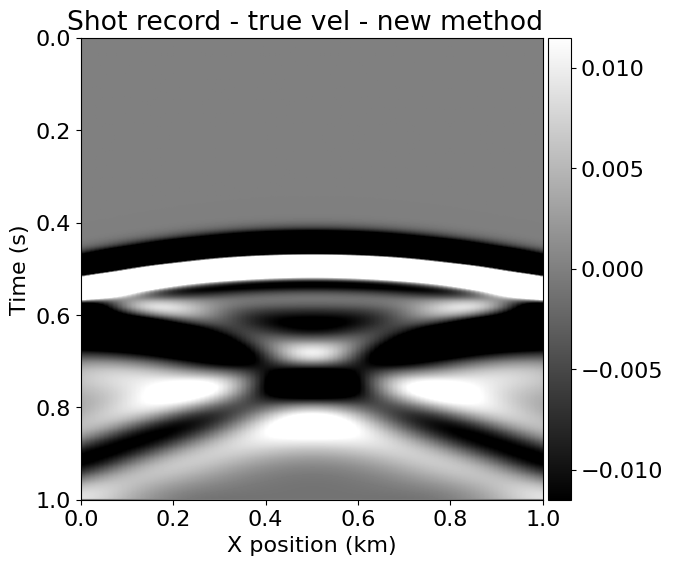

In [27]:
# # Define true and initial model
# shape = (101, 101)  # Number of grid point (nx, nz)
# spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
# origin = (0., 0.)  # Need origin to define relative source and receiver locations

# #Set the number of boundary layers
# nbl = 40

# v = np.full(shape, 2.5, dtype=np.float32)  # 全部初始化为2.5 km/s

# # # 定义圆的中心和半径
# # center_x, center_y = shape[0] // 2, shape[1] // 2  # 圆心位置
# # radius = 30  # 半径为50格

# # # 遍历每个点，如果点在圆内，则设置速度为3 km/s
# # for x in range(shape[0]):
# #     for y in range(shape[1]):
# #         if (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2:
# #             v[x, y] = 3.0

# #True Vp model
# model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, space_order=2, nbl=nbl, bcs="damp")

# vp = model.vp.data

# t0 = 0
# tn=1000.  # Simulation last 1 second (1000 ms)
# dt = model.critical_dt  # Time step from model grid spacing

# time = TimeAxis(start=t0, stop=tn, step=dt)

# u = TimeFunction(name="u", grid=model.grid, 
#                  time_order=2, space_order=2,
#                  save=time.num)

# # pde = (model.m )* u.dt2 - u.laplace + model.damp * u.dt
# pde =  u.dt2 - (1/model.m )*u.laplace + (1/model.m )*model.damp * u.dt

# stencil = Eq(u.forward, solve(pde, u.forward))

# # Src is halfway across model, at depth of 20 m.
# x_extent, _ = model.domain_size
# src_coords = [20, x_extent/2]

# f0 = 0.01  # kHz, peak frequency.
# src = RickerSource(name='src', grid=model.grid, f0=f0, coordinates=src_coords, time_range=time)
# src_term = src.inject(field=u.forward, expr=src * dt**2 * model.m)

# # Recs are distributed across model, at depth of 20 m.
# x_locs = np.linspace(0, x_extent, 101)
# rec_coords = [(980, x) for x in x_locs]

# rec = Receiver(name='rec', npoint=101, grid=model.grid, coordinates=rec_coords, time_range=time)

# rec_term = rec.interpolate(u.forward)

# op_fwd = Operator([stencil] + src_term + rec_term)

# op_fwd(dt=model.critical_dt)

# plt.title('Shot record - true vel - new method', loc='right')
# plot_shotrecord(rec.data, model, t0, tn)

In [38]:
rec.data * 0.1

Data([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      ...,
      [0.000876  , 0.00085949, 0.00083432, ..., 0.00083432, 0.00085949,
       0.000876  ],
      [0.00087522, 0.00085534, 0.00082722, ..., 0.00082722, 0.00085534,
       0.00087522],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]], dtype=float32)

## Some visualisations

In [13]:
# # Quick plot of model.
# plot_velocity(model)


# # Shot the pde function
# # pde = (model.m )* u.dt2 - u.laplace + model.damp * u.dt
# pde


# # We can plot the time signature to see the wavelet via:
# src.show()


# # NOT FOR MANUSCRIPT
# # PLOTS HALF OF FIGURE 1.
# import matplotlib.patches as patches
# from matplotlib.ticker import MultipleLocator

# fig = plt.figure(figsize=(9,9))

# extent = [model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
#           model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]]

# model_param = dict(vmin=1.5, vmax=3.5, cmap="GnBu", aspect=1, extent=extent)

# ax0 = fig.add_subplot(111)
# im = plt.imshow(np.transpose(vp), **model_param)
# cb = plt.colorbar(shrink=0.8)
# ax0.set_ylabel('Depth (km)',fontsize=20)
# ax0.set_xlabel('X position (km)', fontsize=20)
# cb.set_label('Velocity (km/s)', fontsize=20)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# cb.ax.tick_params(labelsize=14)

# plt.scatter(*(rec.coordinates.data[::8, :].T/1000), c='green', clip_on=False, zorder=100)
# plt.text(*rec.coordinates.data[0].T/1000 + [0.02, 0.15], "receivers", color='green', size=14)
# plt.scatter(*(src.coordinates.data.squeeze()/1000), c='red', s=60)
# plt.text(*src.coordinates.data[0]/1000 + [0, 0.15], "source", color='red', size=14)
# plt.scatter(0, 0, c='black', s=160, clip_on=False, zorder=101)
# plt.text(-0.01, -0.03, "Origin", color='k', size=16, ha="right")
# # plt.title("Example velocity model", color='k', size=24)
# # plt.xlim((0, 3))
# # plt.ylim((3, 0))

# minorLocator = MultipleLocator(1/100)
# ax0.xaxis.set_minor_locator(minorLocator)
# ax0.yaxis.set_minor_locator(minorLocator)

# plt.grid(which='minor', alpha=0.3)

# # plt.savefig("model.pdf", dpi=400)
# # plt.savefig("model.png")
# plt.show()


# Load the spyro data

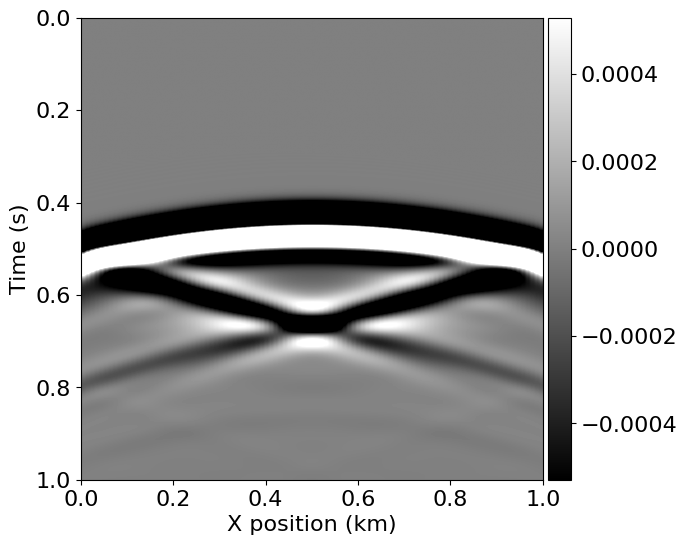

In [31]:
spyro_circle = load_shots(file_name="/Users/yw11823/ACSE/irp/spyro/shots/shot_record_1.dat")
spyro_circle
plot_shotrecord(spyro_circle, model, t0, tn)

## Plot the shot records

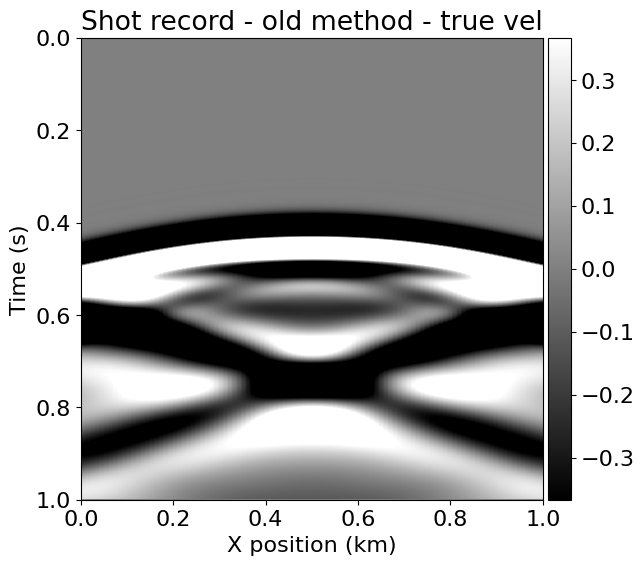

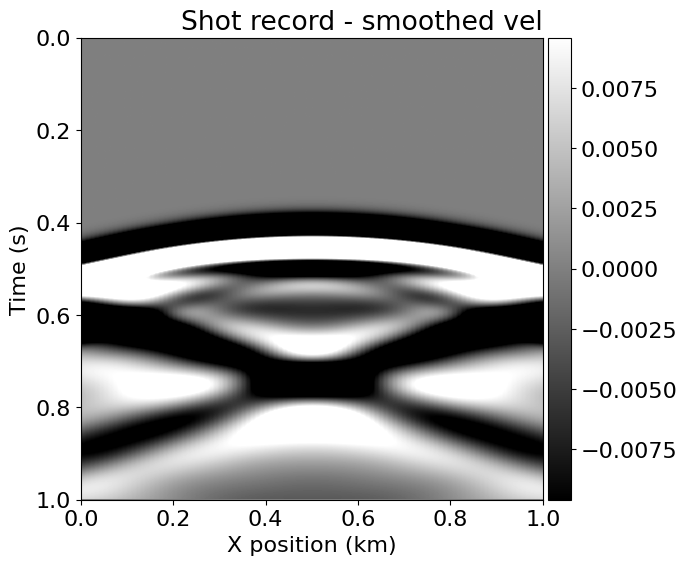

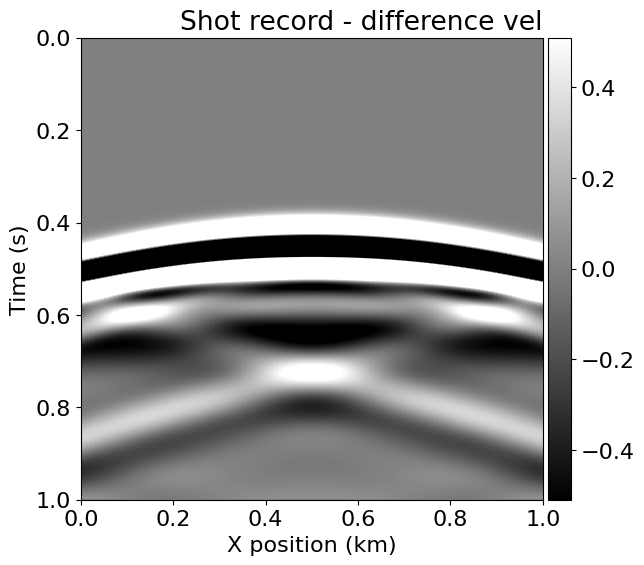

In [26]:
# Plot shot record for true and smooth velocity model and the difference
plt.title('Shot record - old method - true vel', loc='right')
plot_shotrecord(true_d.data, model, t0, tn) # In reality, this would be our data from the experiment
plt.title('Shot record - smoothed vel', loc='right')
plot_shotrecord(rec.data, model, t0, tn) # This is our model data
plt.title('Shot record - difference vel', loc='right')
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn) # This is the data residual

# Compare the results between devito and spyro (True & Smoothed)
## 1. load spyro data

In [90]:
spyro_circle = load_shots(file_name="/Users/yw11823/ACSE/irp/spyro/shots/shot_record_1.dat")
# spyro_circle_1 = load_shots(file_name="/Users/yw11823/ACSE/irp/spyro/shots/shot_record_2.dat")
# spyro_circle - spyro_circle_1

In [18]:
true_d_numpy = true_d.data 
# 去掉最后一行
true_d_numpy = true_d_numpy[:-1, :]


In [78]:
true_d_numpy


Data([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      ...,
      [0.32992781, 0.32669778, 0.32011751, ..., 0.3132409 , 0.3197107 ,
       0.32297759],
      [0.32985126, 0.3263339 , 0.31950813, ..., 0.31266204, 0.31935997,
       0.32289114],
      [0.32969511, 0.32590137, 0.31883504, ..., 0.3120208 , 0.31894444,
       0.32272851]])

In [79]:
spyro_circle

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.05248748e-06, 6.05709782e-06, 5.79909842e-06, ...,
        5.79183276e-06, 6.12123652e-06, 6.19926250e-06],
       [6.06644009e-06, 6.01030630e-06, 5.70104761e-06, ...,
        5.68715204e-06, 6.06524176e-06, 6.20124016e-06],
       [6.07264028e-06, 5.95774122e-06, 5.59937139e-06, ...,
        5.57923501e-06, 6.00384318e-06, 6.19580433e-06]])

## 2. Find the difference between Spyro and Devito
## 2.1 There is no much change if I find the difference between them directly.

In [82]:
a = true_d_numpy - spyro_circle
a

Data([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ],
      ...,
      [0.32992176, 0.32669173, 0.32011171, ..., 0.3132351 , 0.31970458,
       0.32297139],
      [0.3298452 , 0.32632789, 0.31950243, ..., 0.31265635, 0.31935391,
       0.32288493],
      [0.32968904, 0.32589542, 0.31882944, ..., 0.31201522, 0.31893843,
       0.32272232]])

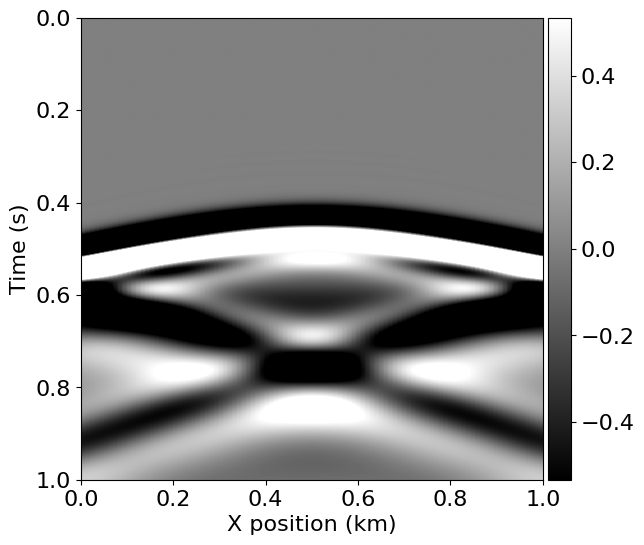

In [83]:
plot_shotrecord(a, model, t0, tn) # In reality, this would be our data from the experiment

## 2.2 Normalized them.

In [19]:
# import numpy as np

# # 假设 data 是从 Devito 和 Spyro 中得到的原始数据
# # 例如：
# # devito_data = ...
# # spyro_data = ...

# def normalize_data(data):
#     min_val = np.min(data)
#     max_val = np.max(data)
#     return (data - min_val) / (max_val - min_val)

# # 进行标准化
# devito_normalized = normalize_data(true_d_numpy)
# spyro_normalized = normalize_data(spyro_circle)

# # 打印标准化后的数据进行比较
# print("Devito Normalized Data:")
# print(devito_normalized)
# print("Spyro Normalized Data:")
# print(spyro_normalized)

Devito Normalized Data:
[[0.32481511 0.32481511 0.32481511 ... 0.32481511 0.32481511 0.32481511]
 [0.32481511 0.32481511 0.32481511 ... 0.32481511 0.32481511 0.32481511]
 [0.32481511 0.32481511 0.32481511 ... 0.32481511 0.32481511 0.32481511]
 ...
 [0.36655042 0.36614183 0.36530943 ... 0.36443955 0.36525797 0.36567123]
 [0.36654074 0.3660958  0.36523235 ... 0.36436633 0.36521361 0.36566029]
 [0.36652098 0.36604108 0.3651472  ... 0.36428521 0.36516104 0.36563972]]
Spyro Normalized Data:
[[0.380862   0.380862   0.380862   ... 0.380862   0.380862   0.380862  ]
 [0.380862   0.380862   0.380862   ... 0.380862   0.380862   0.380862  ]
 [0.380862   0.380862   0.380862   ... 0.380862   0.380862   0.380862  ]
 ...
 [0.38155412 0.38155464 0.38152514 ... 0.38152431 0.38156198 0.3815709 ]
 [0.38155571 0.38154929 0.38151393 ... 0.38151234 0.38155558 0.38157113]
 [0.38155642 0.38154328 0.3815023  ... 0.3815     0.38154856 0.38157051]]


## 2.3 min-max scaling.

In [26]:
devito_data = true_d_numpy
spyro_data = spyro_circle

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 devito_data 和 spyro_data 是从 Devito 和 Spyro 中得到的原始数据
scaling_factor = np.max(np.abs(devito_data)) / np.max(np.abs(spyro_data))

# 缩放 Spyro 数据
scaled_spyro_data = spyro_data * scaling_factor



# 比较差值
difference = devito_data - scaled_spyro_data



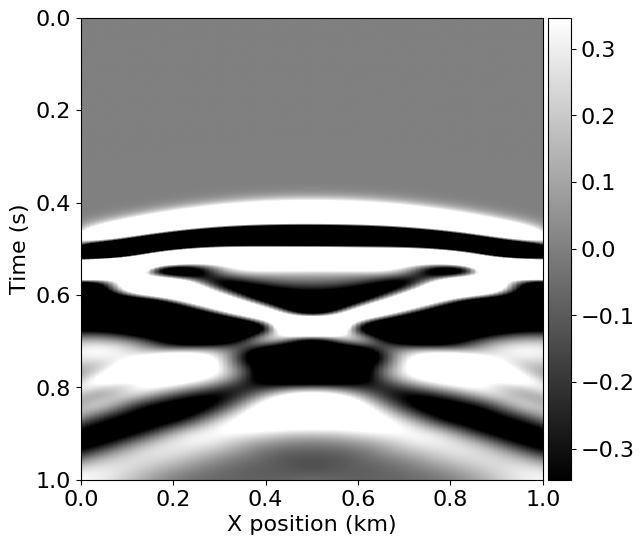

In [80]:
plot_shotrecord(difference, model, t0, tn) # In reality, this would be our data from the experiment

# Marmousi - devito - forward - 2d

smoothed:
3 sources

101 receivers

mesh $3.5km \times 10.0km$

pml = 0.9 km = $ 90 \times 10m$ 

Ricker : feq = 5 HZ ||  f0 = 0.005kHz

tf = 2s, dt=0.001s || tn = 2000ms , dt = 1 ms


true:
3 sources

101 receivers

mesh $3.5km \times 10.0km$

pml = 0.9 km = $ 90 \times 10m$ 

Ricker : feq = 5 HZ ||  f0 = 0.005kHz

tf = 2s, dt=0.00025s || tn = 2000ms , dt = 0.25 ms

In [34]:
# Load 2D Marmousi velocity model from file
# Note that the data corresponds to the velocity of pressure waves in km/s
v = np.fromfile('/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/vp_marmousi_bi', dtype='float32', sep="")

# Re-shape the velocity model v as required by the data
shape = (1601, 401)
spacing = (10., 10.) # physical grid dpacing, (dx, dy), in meters
origin = (0., 0.)
v = v.reshape(shape)

# Cut velocity model size from (1601,401) to (1001,401)
# (This is to speed up the computations a little)
v = v[300:-300, :]

# Gaussian smoothing of the true velocity model
# The 'smothed' version of our velocity model corresponds to something along the lines
# of what an initial guess may look like in a 'real' scenario
v_sm = gaussian_filter(v, sigma=(30, 30), order=0)

#Set the number of boundary layers
nbl = 90

#True Vp model
model = Model(vp=v, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
              shape=v.shape, origin=origin, spacing=spacing, bcs="damp", dt = 0.25)

#Smooth/Initial Vp model
model_sm = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=model.grid,
               shape=v.shape, origin=origin, spacing=spacing, bcs="damp", dt = 1)


# Define acquisition geometry: 
nsrc = 3  # Set the number of sources to 3
nrcv = 101  # Keep the number of receivers at 101

# Set 3 source locations evenly across the horizontal dimension
# model.domain_size[0]
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(1000, 15000, num=nsrc)
src_loc[:, 1] = -10 # Depth at 20m

# Set 101 receiver locations evenly across the whole horizontal dimension
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(100, 17000, num=nrcv)
rcv_loc[:, 1] = -100.  # Depth at 20m

# Create the Geometry
# Along with storing the source and receiver locations defined above this will work out the points in time at
# at which we'll need the source signal and compute them according to the definiction of the Ricker-wavelet
t0 = 0.     # Shot records starts at 0.0
tn = 2000.  # Shot records last 2.0 second (2000 ms)
f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

solver = AcousticWaveSolver(model, geom_all, space_order=4)

# Compute synthetic data with forward operator and calculate the total running time
t1=time.time()
true_d,a, b = solver.forward(vp=model.vp)
end_time = time.time()
running_time = end_time - t1
print("Running Time - devito(true): {:.2f} seconds".format(running_time))

# Compute initial data with forward operator 
t1=time.time()
smoothed_d,a, b = solver.forward(vp=model_sm.vp)
end_time = time.time()
running_time = end_time - t1
print("Running Time - devito(smoothed): {:.2f} seconds".format(running_time))


Running Time - devito(true): 15.46 seconds
Running Time - devito(smoothed): 12.93 seconds


### Some visualizations (e.g plot the 3 sources shot record together (although we should not))

In [95]:
# plt.title('Shot record - true vel', loc='right')
# plot_shotrecord(true_d.data, model, t0, tn)
# plt.title('Shot record - smooth vel', loc='right')
# plot_shotrecord(smooth_d.data, model, t0, tn)
# plt.title('Shot record - difference vel', loc='right')
# plot_shotrecord(true_d.data - smooth_d.data, model, t0, tn)

# # Plot acquisition geometry
# plot_velocity(model, source=geom_all.src_positions,
#               receiver=geom_all.rec_positions[::4, :])

## Plot the shot record for the first source

In [60]:
#Pick the first one source
isrc = 1
geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
                               t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model, geometry, space_order=4)

#Define forward modeling of one source
def modeling_1src(vp_in):    
    # Create symbols to hold the data
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    # Generate modeled data from true model
    _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
    # Compute modeled data and full forward wavefield u0 from smooth model
    _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
    return d_obs, d_syn

#Genearte modeled shot data of both true and smooth velocity models
record, record0 = modeling_1src(model_sm.vp)

Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on ph

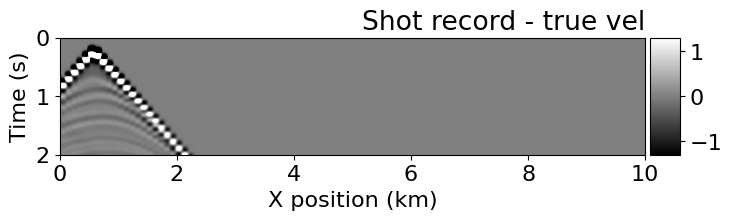

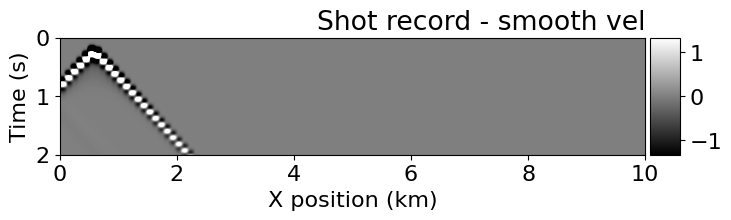

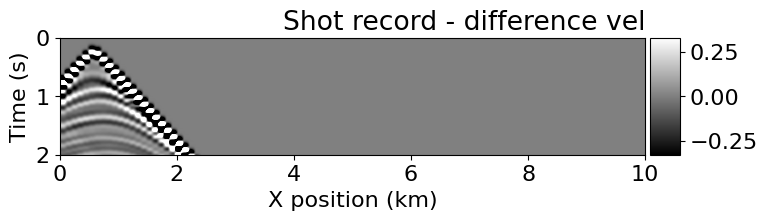

In [100]:
#Plot acquisition geometry and modeled shot data
# from examples.seismic.plotting import plot_velocity, plot_shotrecord
# plot_velocity(model, source=src_loc[isrc-1:isrc,:], receiver=rcv_loc[::4]);
plt.title('Shot record - true vel', loc='right')
plot_shotrecord(record.data, model, t0, tn)
plt.title('Shot record - smooth vel', loc='right')
plot_shotrecord(record0.data, model, t0, tn)
plt.title('Shot record - difference vel', loc='right')
plot_shotrecord(record0.data - record.data, model, t0, tn)

## Plotting the shot record of the second one and the third one source 

In [ ]:
# #Pick the second one source
# isrc = 2
# geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
#                                t0, tn, f0=f0, src_type='Ricker')
# solver = AcousticWaveSolver(model, geometry, space_order=4)

# #Define forward modeling of one source
# def modeling_1src(vp_in):    
#     # Create symbols to hold the data
#     d_obs = Receiver(name='d_obs', grid=model.grid,
#                      time_range=geometry.time_axis,
#                      coordinates=geometry.rec_positions)
#     d_syn = Receiver(name='d_syn', grid=model.grid,
#                      time_range=geometry.time_axis,
#                      coordinates=geometry.rec_positions)
#     # Generate modeled data from true model
#     _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
#     # Compute modeled data and full forward wavefield u0 from smooth model
#     _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
#     return d_obs, d_syn

# #Genearte modeled shot data of both true and smooth velocity models
# record, record0 = modeling_1src(model_sm.vp)

# #Plot acquisition geometry and modeled shot data
# # from examples.seismic.plotting import plot_velocity, plot_shotrecord
# # plot_velocity(model, source=src_loc[isrc-1:isrc,:], receiver=rcv_loc[::4]);
# plt.title('Acquisition geometry (1 shot)', loc='right')
# plot_shotrecord(record.data, model, t0, tn)
# plt.title('Shot record - true vel', loc='right')
# plot_shotrecord(record0.data, model, t0, tn)
# plt.title('Shot record - smooth vel', loc='right')
# plot_shotrecord(record0.data - record.data, model, t0, tn)

In [ ]:
# #Pick the third one source
# isrc = 3
# geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
#                                t0, tn, f0=f0, src_type='Ricker')
# solver = AcousticWaveSolver(model, geometry, space_order=4)

# #Define forward modeling of one source
# def modeling_1src(vp_in):    
#     # Create symbols to hold the data
#     d_obs = Receiver(name='d_obs', grid=model.grid,
#                      time_range=geometry.time_axis,
#                      coordinates=geometry.rec_positions)
#     d_syn = Receiver(name='d_syn', grid=model.grid,
#                      time_range=geometry.time_axis,
#                      coordinates=geometry.rec_positions)
#     # Generate modeled data from true model
#     _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
#     # Compute modeled data and full forward wavefield u0 from smooth model
#     _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
#     return d_obs, d_syn

# #Genearte modeled shot data of both true and smooth velocity models
# record, record0 = modeling_1src(model_sm.vp)

# #Plot acquisition geometry and modeled shot data
# # from examples.seismic.plotting import plot_velocity, plot_shotrecord
# # plot_velocity(model, source=src_loc[isrc-1:isrc,:], receiver=rcv_loc[::4]);
# plt.title('Acquisition geometry (1 shot)', loc='right')
# plot_shotrecord(record.data, model, t0, tn)
# plt.title('Shot record - true vel', loc='right')
# plot_shotrecord(record0.data, model, t0, tn)
# plt.title('Shot record - smooth vel', loc='right')
# plot_shotrecord(record0.data - record.data, model, t0, tn)

# Comparing the Spyro and Devito

In [35]:
true_d = true_d.data
true_d = true_d[:-1, :]
true_d

Data([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ],
      [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ],
      [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ],
      ...,
      [ 0.09972561,  0.0873806 , -0.00131308, ...,  0.        ,
        0.        ,  0.        ],
      [ 0.100012  ,  0.08686209, -0.00244439, ...,  0.        ,
        0.        ,  0.        ],
      [ 0.10029417,  0.08633384, -0.00357643, ...,  0.        ,
        0.        ,  0.        ]], dtype=float32)

In [36]:
smoothed_d = smoothed_d.data
smoothed_d = smoothed_d[:-1, :]

In [50]:
spyro_M2d_p1 = load_shots(file_name="/Users/yw11823/ACSE/irp/spyro/M2dshot_record_1.dat")

In [61]:
record = record.data
record = record[:-1, :]

In [62]:
spyro_M2d_p1

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.22483081e-05,  1.07814528e-04,  1.86283241e-04, ...,
        -8.18769009e-31,  1.40136011e-31,  5.74517586e-32],
       [ 4.29454636e-05,  1.10590542e-04,  1.84557259e-04, ...,
        -7.69298888e-31,  1.52671446e-31,  5.16170992e-32],
       [ 4.36368959e-05,  1.13389007e-04,  1.82823156e-04, ...,
        -7.01294029e-31,  1.61932737e-31,  4.44556702e-32]])

In [66]:
spyro_M2d_p1 = spyro_M2d_p1 * 1000

In [67]:
spyro_M2d_p1

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.22483081e-02,  1.07814528e-01,  1.86283241e-01, ...,
        -8.18769009e-28,  1.40136011e-28,  5.74517586e-29],
       [ 4.29454636e-02,  1.10590542e-01,  1.84557259e-01, ...,
        -7.69298888e-28,  1.52671446e-28,  5.16170992e-29],
       [ 4.36368959e-02,  1.13389007e-01,  1.82823156e-01, ...,
        -7.01294029e-28,  1.61932737e-28,  4.44556702e-29]])

In [63]:
record

Data([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ],
      [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ],
      [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ],
      ...,
      [ 0.09972561,  0.0873806 , -0.00131308, ...,  0.        ,
        0.        ,  0.        ],
      [ 0.100012  ,  0.08686209, -0.00244439, ...,  0.        ,
        0.        ,  0.        ],
      [ 0.10029417,  0.08633384, -0.00357643, ...,  0.        ,
        0.        ,  0.        ]], dtype=float32)

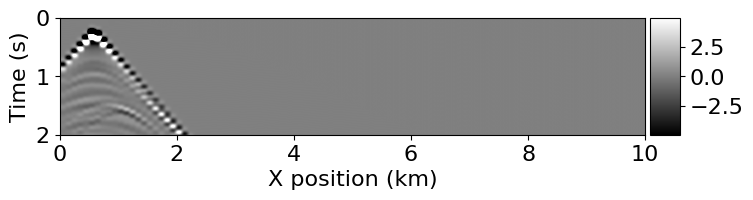

In [68]:
plot_shotrecord(spyro_M2d_p1 - record, model, t0, tn)

In [70]:
spyro_M3d = load_shots(file_name="/Users/yw11823/ACSE/irp/spyro/shots/shot_record_2.dat")
spyro_M2d_p1 - spyro_M3d

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])